In [1]:
import json
import os
import pickle
import numpy as np
import detectron2
import torch

import pathlib
import pandas as pd
import pycocotools.mask as RLE
import skimage
import skimage.io

import seaborn as sns
import skimage.measure



import matplotlib.pyplot as plt

from detectron2.structures import instances, Boxes
import torch


ampis_root = pathlib.Path('../../src/')
assert ampis_root.is_dir()

import sys
sys.path.append(str(ampis_root))

import explore_data_photonic_cval


from ampis import analyze, data_utils
from ampis.structures import instance_set
from ampis.visualize import quick_visualize_iset, quick_visualize_iset_custom

In [2]:
dataset_name_ = 'photonic'

gt_root = pathlib.Path('../../data/raw/photonic')
pred_cval_root = pathlib.Path('/media/ryan/TOSHIBA EXT/Research/Projects/'
                              'AMPIS_TRAINING_DATA/photonic')

assert gt_root.is_dir()
assert pred_cval_root.is_dir()


In [3]:
### visualize typical
cval_id = 2 # select which fold to look at
pred_root = pred_cval_root / 'output/cval_{}/Figures/masks/predicted/model_final/outputs.pickle'.format(cval_id)
pred_metrics = pred_cval_root / 'output/cval_{}/metrics.json'.format(cval_id)
assert pred_root.is_file()
assert pred_metrics.is_file()

In [4]:
with open(pred_metrics, 'rb') as f:
    jsondata = [json.loads(x) for x in f.readlines()]

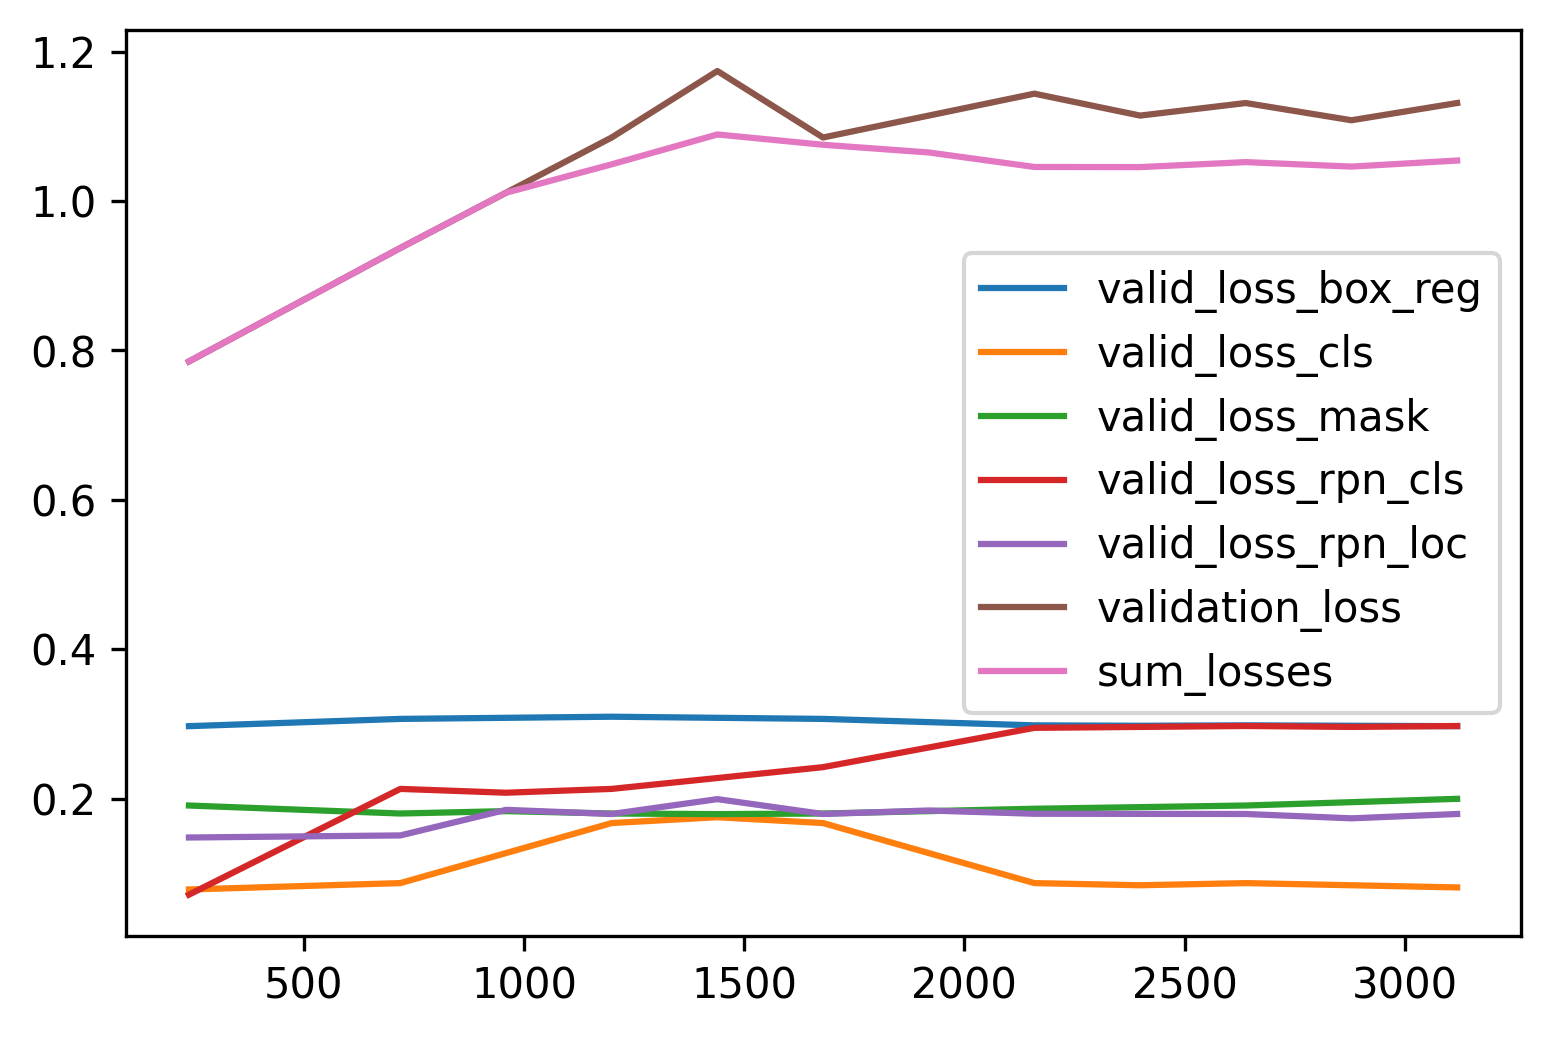

In [5]:
val_entries = [x for x in jsondata if 'validation_loss' in x.keys()]
val_keys = [k for k in val_entries[0].keys() if 'val' in k]

fig, ax = plt.subplots(dpi=300)


results = {}
results['iter'] = [x['iteration'] for x in val_entries]
for k in val_entries[0].keys():
    if 'val' in k:
        results[k] = [x[k] for x in val_entries ]
        ax.plot(results['iter'], results[k], label=k)
        
df = pd.DataFrame(results)
df['sum_losses'] = df[[x for x in df.columns if 'valid_' in x]].sum(axis=1)
ax.plot(results['iter'], df['sum_losses'], label='sum_losses')
leg = ax.legend()

In [6]:
# predicted data loaded first- organized by training followed by validation
with open(pred_root, 'rb') as f:
    pred_data = pickle.load(f)

pred_instances = [analyze.instance_set().read_from_model_out(
    x,True) for x in pred_data.values()]
    
    
gt_instances = [analyze.instance_set().read_from_ddict(x, True)
              for x in explore_data_photonic_cval.get_data_dicts(gt_root)]

metadata = explore_data_photonic_cval.get_metadata()

pred_instances, gt_instances = analyze.align_instance_sets(pred_instances, gt_instances)

In [7]:
for pred, gt in zip(pred_instances, gt_instances):
    pred.dataset_class = 'Training' if 'Training' in pred.dataset_class else 'Validation'
    gt.dataset_class = pred.dataset_class

In [8]:
# ground truth
gt = gt_instances[-1]

# predicted
pred = pred_instances[-1]
print(pred.filepath)

K128_02_r1r2c1c2_360-720-000-512.png


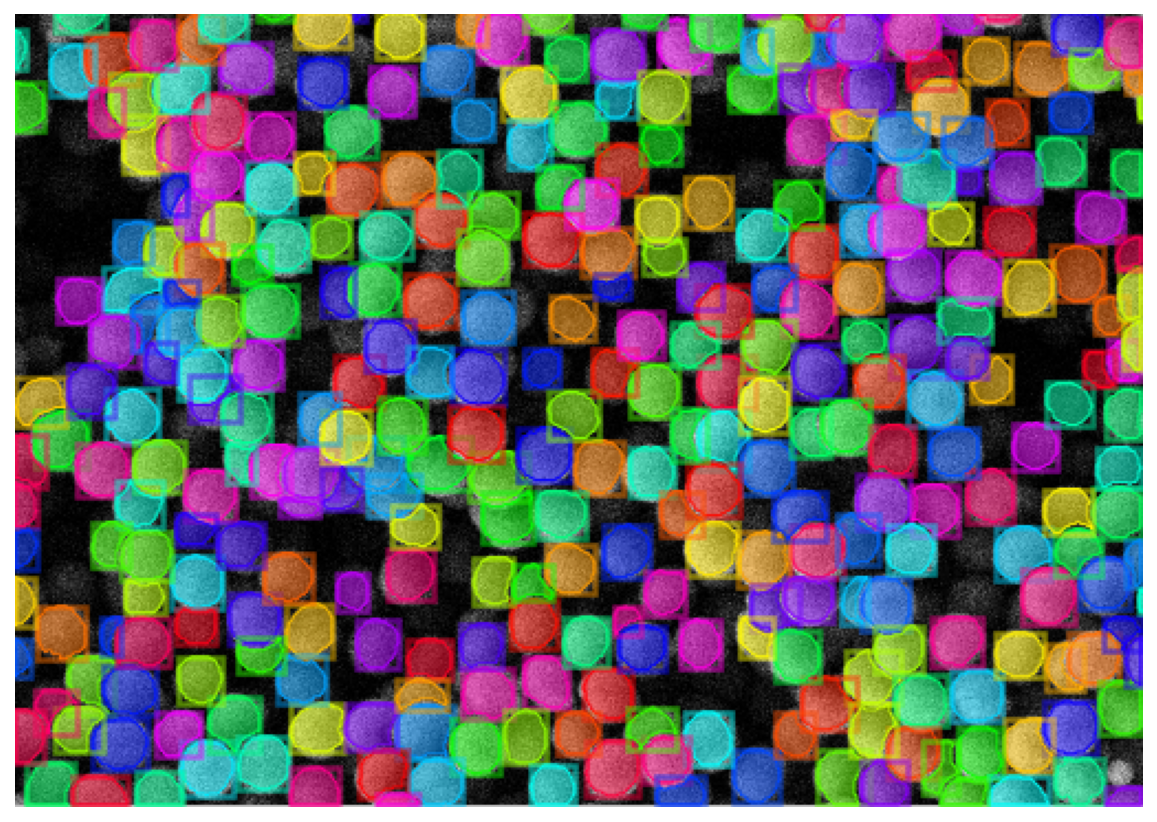

In [9]:
img = skimage.io.imread(gt.filepath)
img = skimage.color.gray2rgb(img)

quick_visualize_iset(img, metadata, gt)

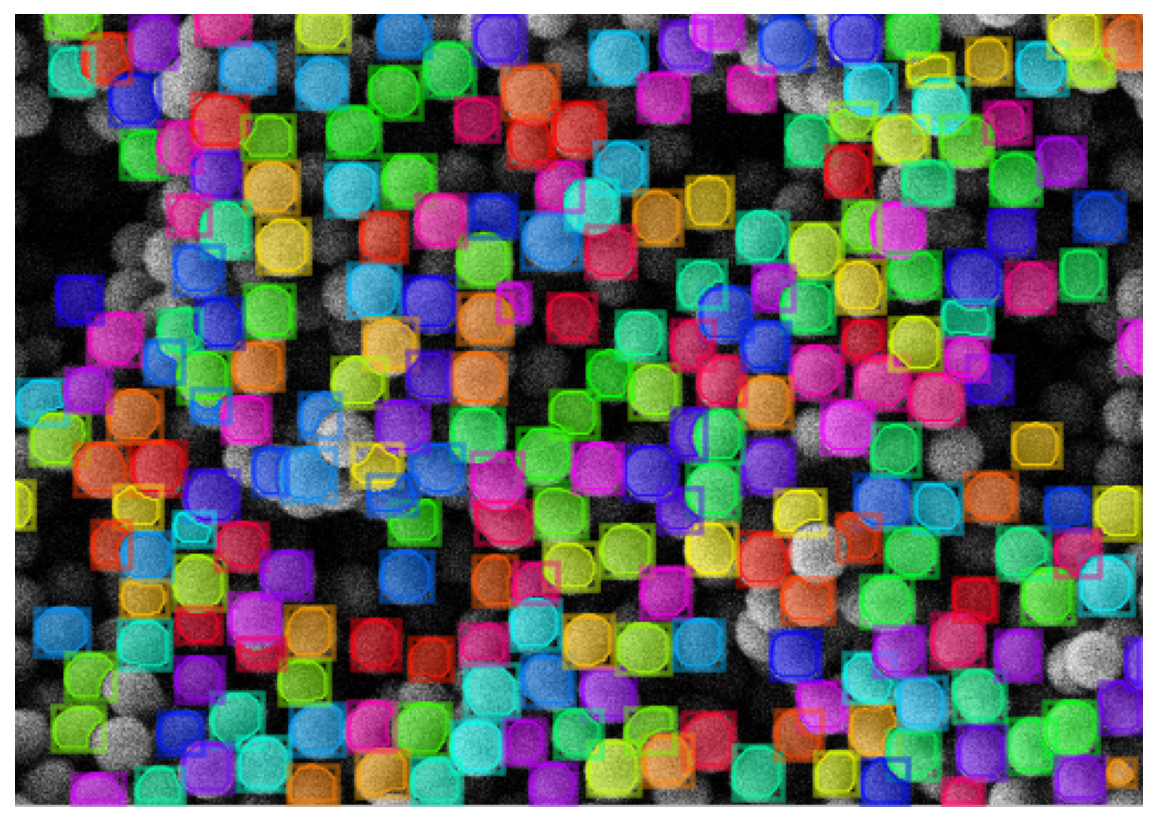

In [10]:
quick_visualize_iset(img, metadata, pred)


In [11]:
for isetlist in [gt_instances, pred_instances]:
    for iset in isetlist:
        iset.instances = iset.filter_mask_size(min_thresh=0, to_rle=True)
        

In [12]:
mmr = [analyze.mask_match_stats(x.instances.masks, y.instances.masks, size=x.instances.image_size) 
       for x, y in zip(gt_instances, pred_instances)]

match_precision = [x['match_precision'] for x in mmr]
match_recall = [x['match_recall'] for x in mmr]

mask_precision = [x['mask_precision'] for x in mmr]
mask_recall = [x['mask_recall'] for x in mmr]

mask_precision_global = [sum(x['mask_tp'])/(sum(x['mask_tp'])+sum(x['mask_fp'])) for x in mmr]
mask_recall_global = [sum(x['mask_tp'])/(sum(x['mask_tp'])+sum(x['mask_fn'])) for x in mmr]

In [13]:
def generate_labels(ins):
    labels = []
    counts = {'Training':0,
             'Validation':0,
             'Test':0}
    
    for iset in ins:
        counts[iset.dataset_class] += 1
        labels.append('{} {}'.format(iset.dataset_class, counts[iset.dataset_class]))
    return labels

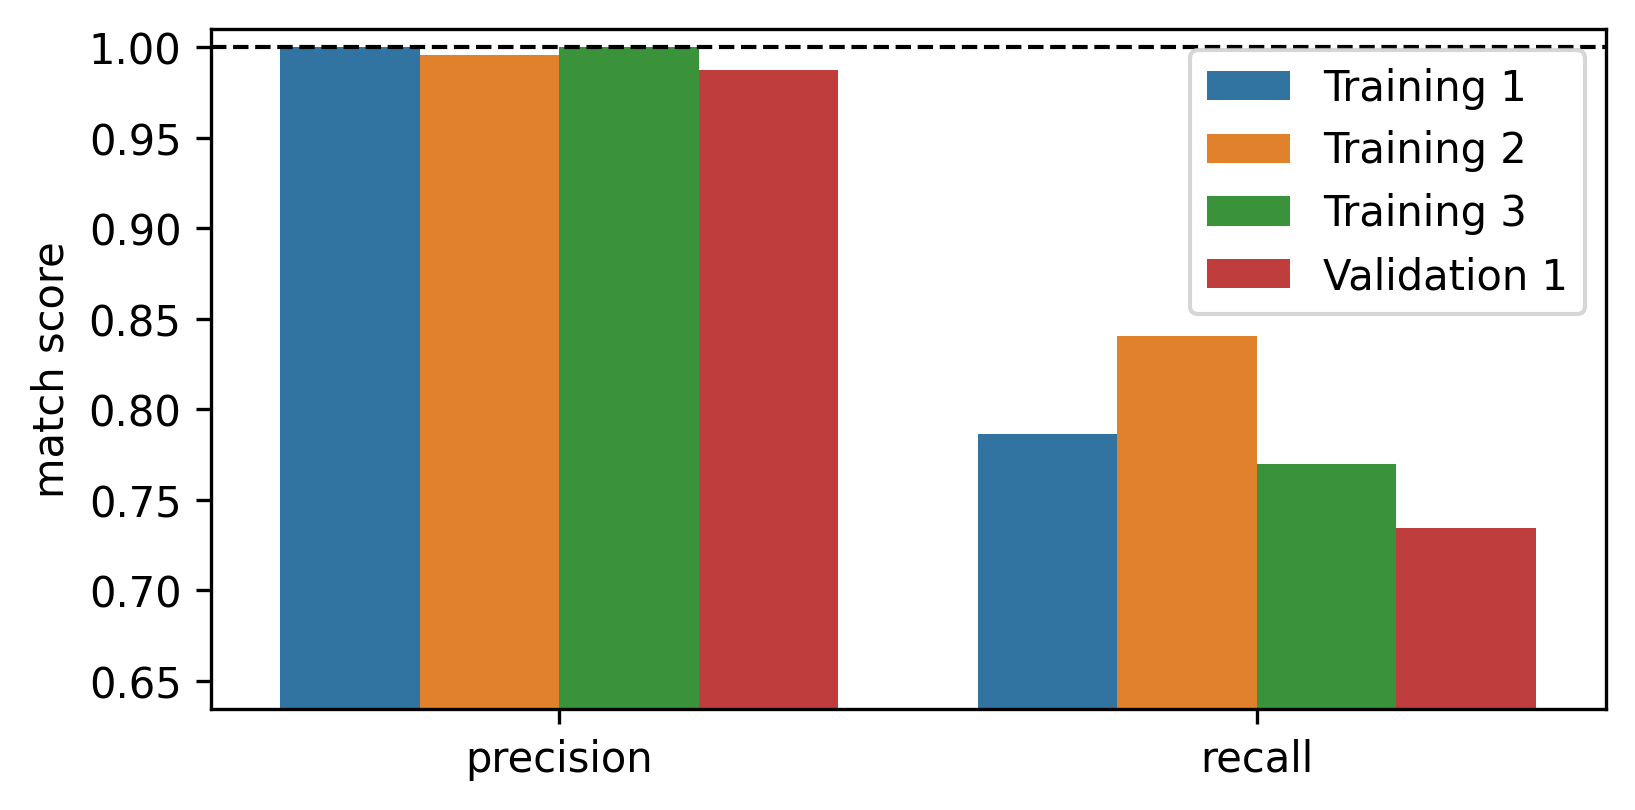

In [14]:
files = generate_labels(gt_instances)

files_list = []
[files_list.extend(files) for _ in range(2)]


y = np.concatenate((match_precision, match_recall), axis=0)

x = []
[x.extend([i]*len(files)) for i in ['precision', 'recall']]

df_match = pd.DataFrame()

df_match['files'] = files_list
df_match['y'] = y
df_match['x'] = x

fig, ax = plt.subplots(figsize=(6,3), dpi=300)
sns.barplot(x="x", y="y",  hue='files', data=df_match, ax=ax)
ax.legend(bbox_to_anchor=(1,1))
ax.set_ylabel('match score')
ax.set_xlabel('')
xlims = ax.get_xlim()
ax.plot(xlims, [1,1], '--k', linewidth=1)
ax.set_xlim(xlims)
ax.set_ylim([min(y)-0.1,1.01])

plt.show()


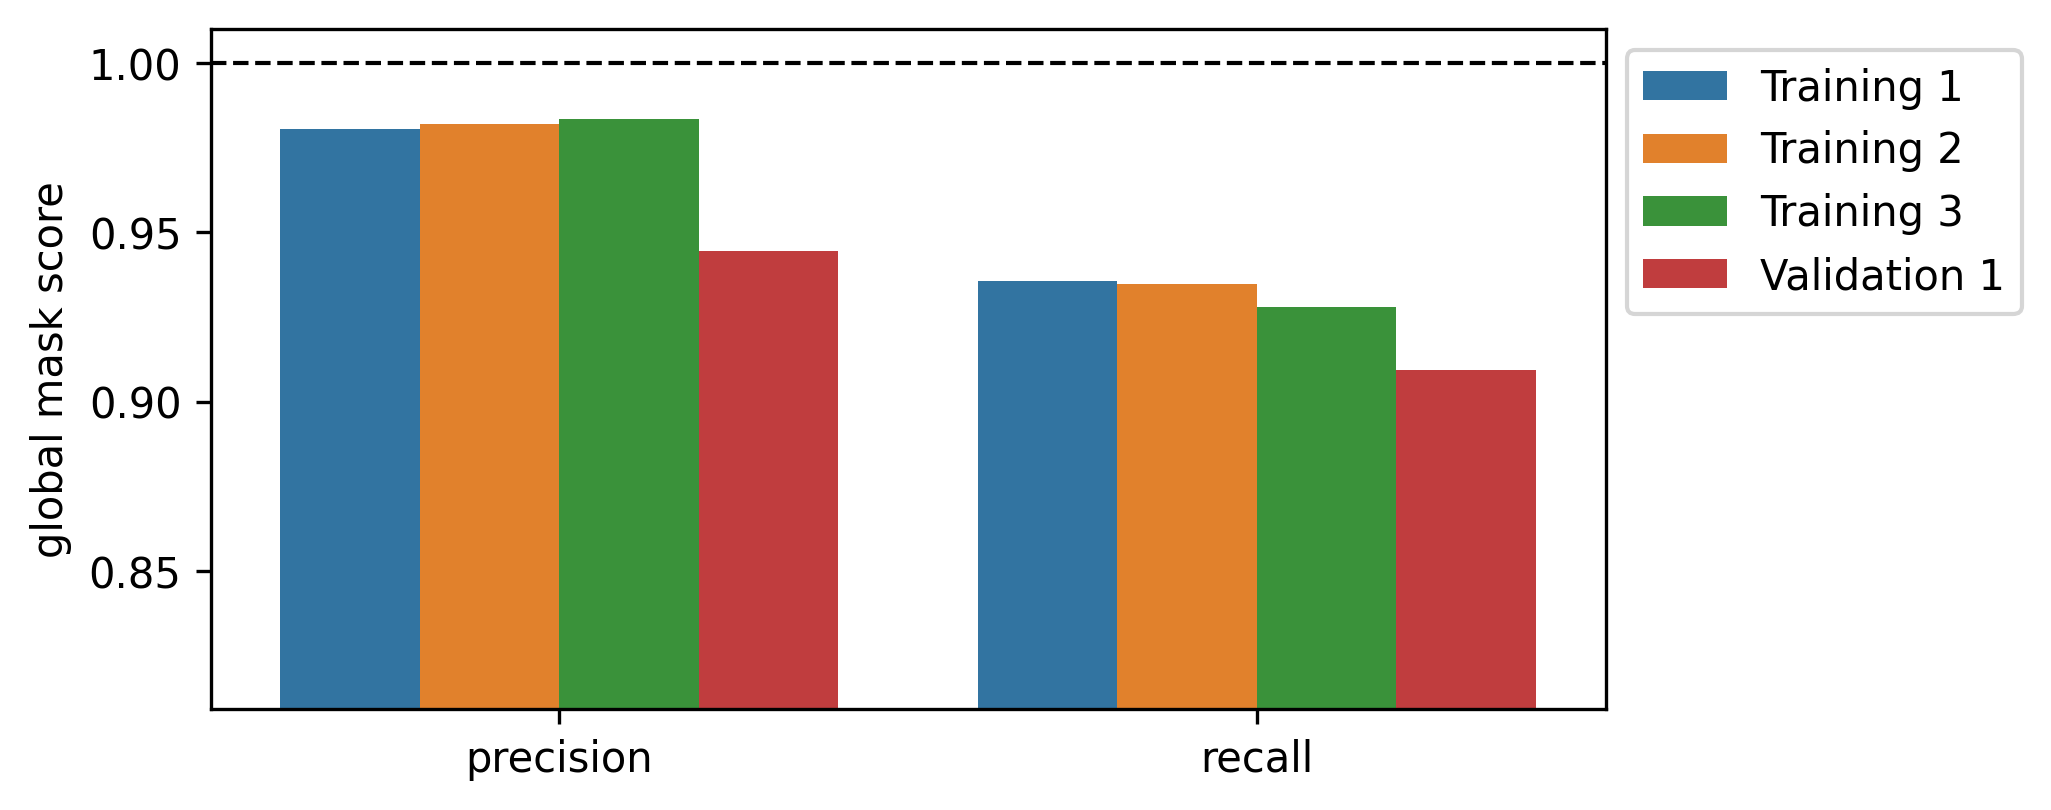

In [15]:
files = generate_labels(gt_instances)

files_list = []
[files_list.extend(files) for _ in range(2)]


y = np.concatenate((mask_precision_global, mask_recall_global), axis=0)

x = []
[x.extend([i]*len(files)) for i in ['precision', 'recall']]

df_match = pd.DataFrame()

df_match['files'] = files_list
df_match['y'] = y
df_match['x'] = x

fig, ax = plt.subplots(figsize=(6,3), dpi=300)
sns.barplot(x="x", y="y",  hue='files', data=df_match, ax=ax)
ax.legend(bbox_to_anchor=(1,1))
ax.set_ylabel('global mask score')
ax.set_xlabel('')
xlims = ax.get_xlim()
ax.plot(xlims, [1,1], '--k', linewidth=1)
ax.set_xlim(xlims)
ax.set_ylim([min(y)-0.1,1.01])

plt.show()


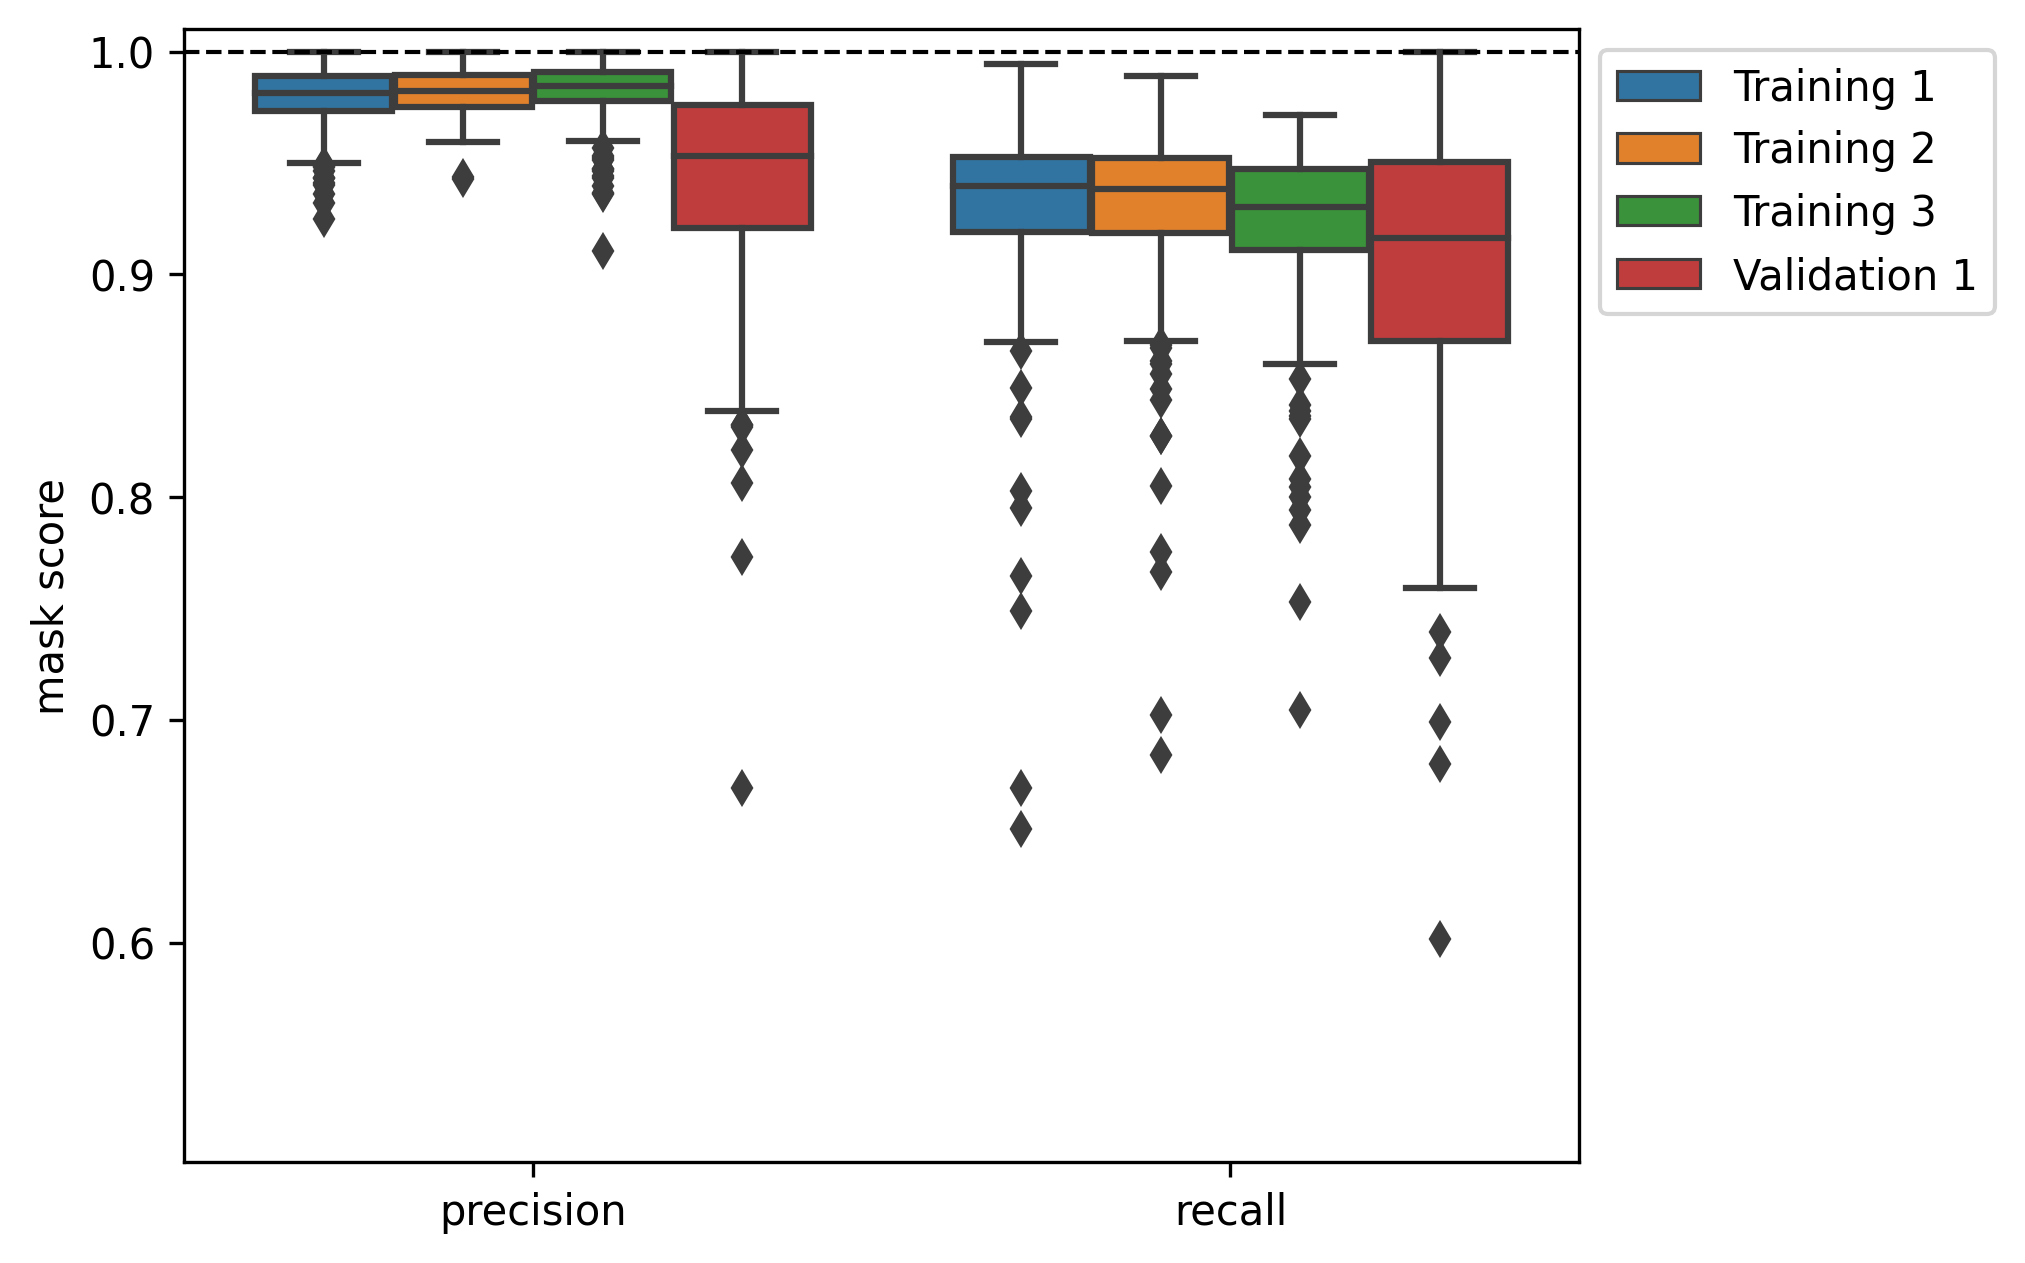

In [16]:
y = np.concatenate((mask_precision, mask_recall,), axis=0)

newx = []
newy = []
newfiles = []

for xi, yi, file in zip(x, y, files_list):
    for yii in yi:
        newx.append(xi)
        newy.append(yii)
        newfiles.append(file)
df_mask = pd.DataFrame()

df_mask['files'] = newfiles
df_mask['y'] = newy
df_mask['x'] = newx

fig, ax = plt.subplots(figsize=(6,5), dpi=300)
#box = ax.get_position()
#ax.set_position([0,0,box.width,box.height])
sns.boxplot(x="x", y="y",  hue='files', data=df_mask, 
            ax=ax, showfliers=True)
l1 = ax.legend(bbox_to_anchor=(1.0,1.0))
ax.set_ylabel('mask score')
ax.set_xlabel('')
xlims = ax.get_xlim()
ax.plot(xlims, [1,1], '--k', linewidth=1)
ax.set_xlim(xlims)
ax.set_ylim([min(newy)-0.1, 1.01])
plt.show()

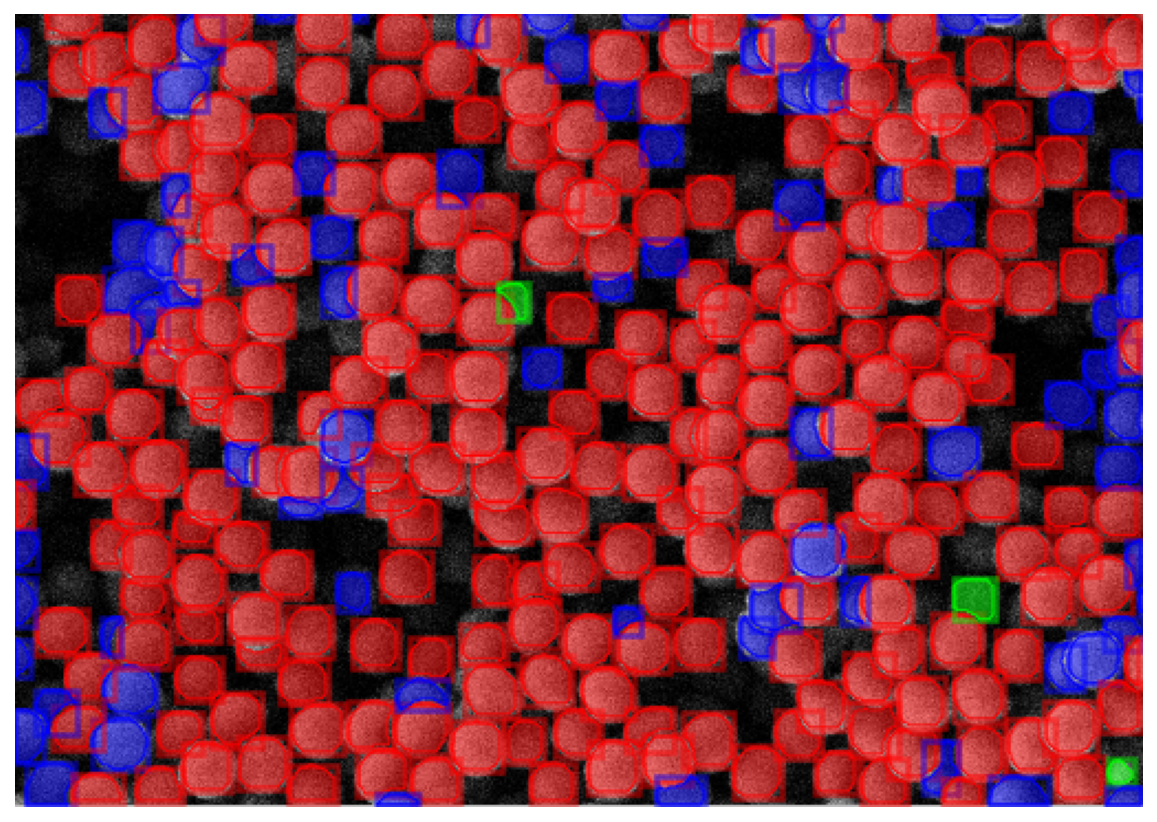

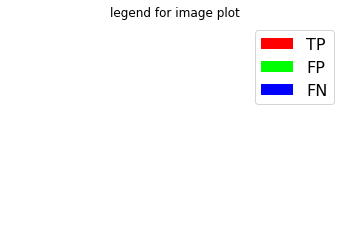

In [17]:
pred = pred_instances[-1]
gt = gt_instances[-1]

gtmasks = analyze.masks_to_rle(gt.instances.masks, gt.instances.image_size)
predmasks = analyze.masks_to_rle(pred.instances.masks, pred.instances.image_size)
match_results_ = analyze.rle_instance_matcher(gtmasks, predmasks)


is_match, colormap = analyze.match_visualizer(gt, pred, match_results_)

img = skimage.io.imread(gt.filepath)
img = skimage.color.gray2rgb(img)
quick_visualize_iset(img, metadata, is_match)

fig, ax = plt.subplots(1,1)
for i, name in enumerate(['TP','FP','FN']):
    ax.bar(-1000-i, 4+i, color=colormap[name], label=name)
    
ax.axis([0,10,0,10])
ax.legend(fontsize=16)
ax.set_title('legend for image plot')
ax.axis('off')
    
plt.show()


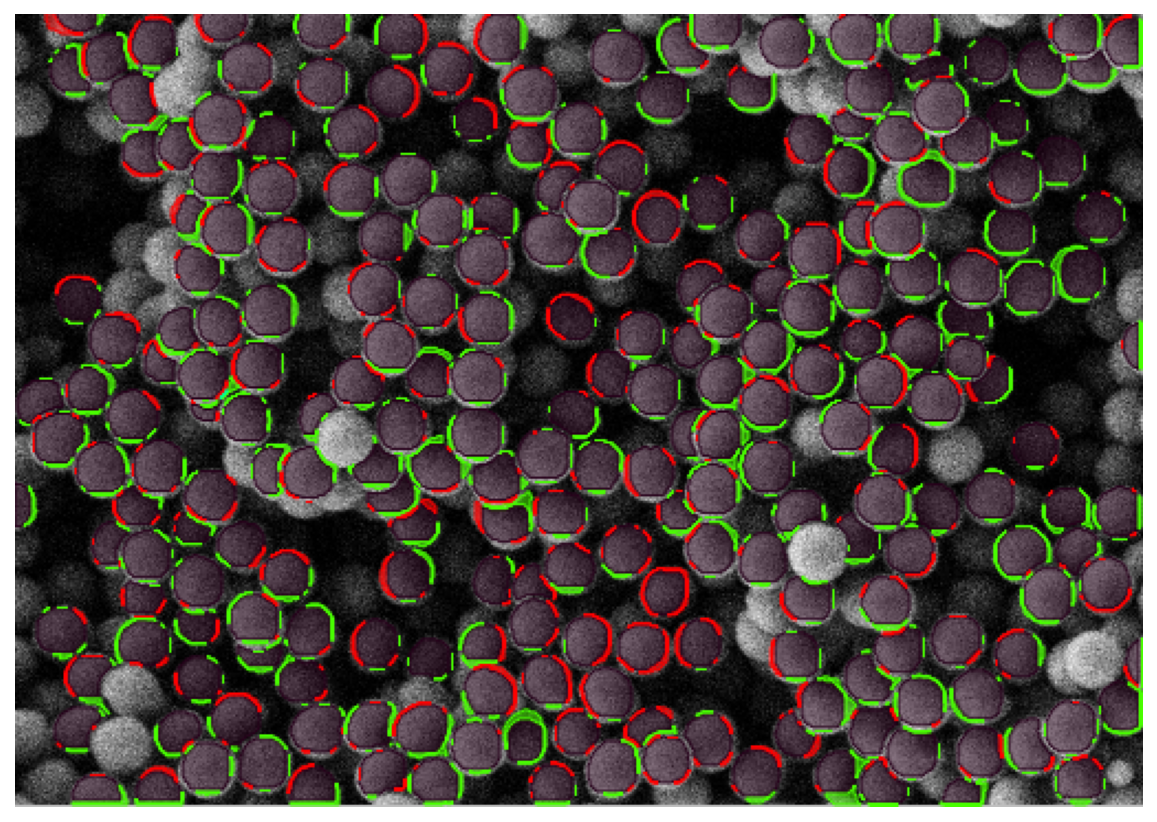

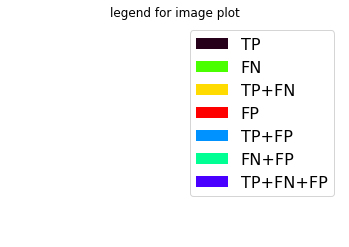

In [18]:
mask_iset, color_labels = analyze.mask_visualizer(gt.instances.masks, pred.instances.masks, size=gt.instances.image_size)

img = skimage.io.imread(gt.filepath)
img = skimage.color.gray2rgb(img)
colors = sns.color_palette(n_colors=7)
colors[1] = [1,0,0]
colors[2] = [0,1,0]
colors[3] = [0.8, 0.8, 0.8]

quick_visualize_iset(img, metadata, mask_iset)


fig, ax = plt.subplots(1,1)
for i in range(7):
    ax.bar(-1000-i, 4+i, color=mask_iset.instances.colors[i], label=color_labels[i+1])
    ax.axis('off')
    
ax.axis([0,10,0,10])
ax.legend(fontsize=16)
ax.set_title('legend for image plot')

    
plt.show()


In [19]:
cval_id = 3 # select which fold to look at
def cval_mmr(cval_id):
    """
    analyze results for a single fold during cross validation
    """
    pred_root = pred_cval_root / 'output/cval_{}/Figures/masks/predicted/model_final/outputs.pickle'.format(cval_id)


    # predicted data loaded first- organized by training followed by validation
    with open(pred_root, 'rb') as f:
        pred_data = pickle.load(f)

    pred_instances = [analyze.instance_set().read_from_model_out(
        x,True) for x in pred_data.values()]

    gt_instances = [analyze.instance_set().read_from_ddict(x, True)
                  for x in explore_data_photonic_cval.get_data_dicts(gt_root)]

    metadata = explore_data_photonic_cval.get_metadata()

    pred_instances, gt_instances = analyze.align_instance_sets(pred_instances, gt_instances)



    gt_instances = [analyze.instance_set().read_from_ddict(x, True)
                  for x in explore_data_photonic_cval.get_data_dicts(gt_root)]

    metadata = explore_data_photonic_cval.get_metadata()

    pred_instances, gt_instances = analyze.align_instance_sets(pred_instances, gt_instances)

    for pred, gt in zip(pred_instances, gt_instances):
        pred.dataset_class = 'Training' if 'Training' in pred.dataset_class else 'Validation'
        gt.dataset_class = pred.dataset_class

    pred_instances_val = [x for x in pred_instances if x.dataset_class == 'Validation']
    gt_instances_val = [x for x in gt_instances if x.dataset_class == 'Validation']

    for isetlist in [gt_instances, pred_instances]:
        for iset in isetlist:
            iset.instances = iset.filter_mask_size(min_thresh=0, to_rle=True)

    mmr = [analyze.mask_match_stats(x.instances.masks, y.instances.masks, size=x.instances.image_size) 
           for x, y in zip(gt_instances_val, pred_instances_val)]
    return mmr, gt_instances_val, pred_instances_val

cval_folds = []
cval_gt_instances = []
cval_pred_instances = []

for i in range(4):
    mmr, gt_instances, pred_instances = cval_mmr(i)
    cval_folds.append(mmr)
    cval_gt_instances.append(gt_instances)
    cval_pred_instances.append(pred_instances)
    
#cval_folds = [cval_mmr(i) for i in range(5)]



In [20]:
nfolds = len(cval_folds)
cval_match_precision = np.zeros(nfolds)
cval_match_recall = np.zeros(nfolds)

cval_mask_precision = np.zeros(nfolds)
cval_mask_recall = np.zeros(nfolds)



for i, fold in enumerate(cval_folds):
    match_tp = sum([len(x['match_tp']) for x in fold])
    match_fp = sum([len(x['match_fp']) for x in fold])
    match_fn = sum([len(x['match_fn']) for x in fold])
    
    mask_tp = sum([sum(x['mask_tp']) for x in fold])
    mask_fp = sum([sum(x['mask_fp']) for x in fold])
    mask_fn = sum([sum(x['mask_fn']) for x in fold])


    
    cval_match_precision[i] = match_tp/(match_tp+match_fp)
    cval_match_recall[i] = match_tp/(match_tp+match_fn)
    
    cval_mask_precision[i] = mask_tp/(mask_tp+mask_fp)
    cval_mask_recall[i] = mask_tp/(mask_tp+mask_fn)
    
    

In [21]:
print('score\t\t\t1      2     3     4     5       avg     std ')
for label, scores in zip(['cval_match_precision', 'cval_match_recall', 'cval_mask_precision', 'cval_mask_recall'], [cval_match_precision, cval_match_recall, cval_mask_precision, cval_mask_recall]):
    print(label, end='\t')
    print(np.round(scores, decimals=3), end='\t')
    print(np.round(scores.mean(), decimals=3), end='\t')
    print(np.round(np.std(scores), decimals=3))

score			1      2     3     4     5       avg     std 
cval_match_precision	[0.974 1.    0.988 1.   ]	0.99	0.011
cval_match_recall	[0.802 0.728 0.735 0.681]	0.736	0.043
cval_mask_precision	[0.939 0.959 0.945 0.954]	0.949	0.008
cval_mask_recall	[0.909 0.9   0.909 0.891]	0.902	0.008


In [22]:
for gt_or_pred in [cval_gt_instances, cval_pred_instances]:
    for isetlist in gt_or_pred:
        for iset in isetlist:
            iset.compute_rprops()
    

In [24]:
results = {'gt_val': cval_gt_instances,
          'pred_val': cval_pred_instances}

save=False
if save:
    with open('photonic_cval_validation_instance_sets.pickle', 'wb') as f:
        pickle.dump(results, f)